# Phân tích và Khám phá dữ liệu.

Tìm câu trả lời cho các câu hỏi nghiên cứu:
+ Những đặc trưng và từ khóa nào mang tính phân biệt cao nhất trong một tin tuyển dụng giả mạo. 

Mô tả dữ liệu: 
+ Job_id : id của công việc 
+ title : tiêu đề của bài báo tuyển dụng
+ location : địa chỉ của công ty - nơi làm việc
+ department : vị trí công việc
+ salary_range : Khoảng lương
+ company_profile : profile của công ty
+ description : Mô tả 
+ requirements : yêu cầu của công việc 
+ benefits : quyền lợi 
+ telecommuting : có để số liên lạc hay không 
+ has_company_logo : công ty có logo hay không 
+ has_questions : có câu hỏi hay không 
+ employment_type : kiểu công việc (full-time, part-time, other)
+ required_experience : yêu cầu kinh nghiệm
+ required_education : yêu cầu học vị
+ industry : lĩnh vực công việc
+ function : vai trò công việc
+ fraudulent : gian lận hay không 


Load Library

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import sys 
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
import warnings
warnings.filterwarnings("ignore")
import spacy
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
import re
from src.preprocessor_utils import clear_text, normalize_text


Load Dataset

In [41]:
path_df = os.path.join(project_root,"data","fake_job_postings.csv")
df = pd.read_csv(path_df)

In [42]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [44]:
df.shape

(17880, 18)

<Axes: >

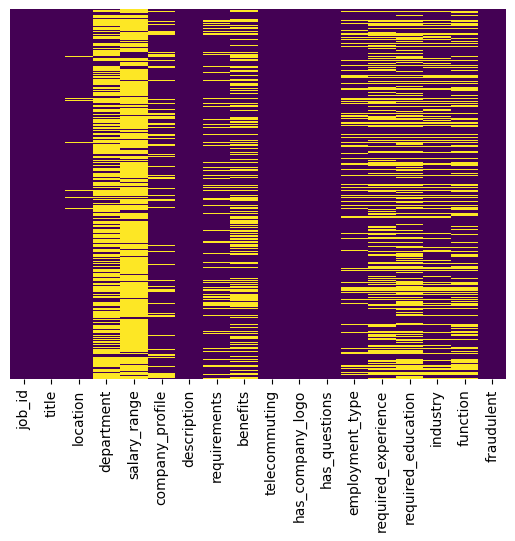

In [45]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap = "viridis")

In [46]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [47]:
df.duplicated().sum()

0

Từ biều đồ heatmap ta thấy được là có khá nhiều dữ liệu bị trống nhiều nhất là cột salary_range có nhiều giá trị trống nhất và dữ liệu không có giá trị nào bị trùng lập


In [48]:
categorical = []
numerical = []
for col in df.columns:
    if df[col].dtype != 'object':
        numerical.append(col)
    else:
        categorical.append(col)
print(categorical)
print(numerical)

['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']


In [49]:
df[numerical].describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


ta sẽ xem độ tương quan giữa các cột 

In [50]:
df[numerical].corr()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
job_id,1.000000,-0.004559,-0.014539,-0.087025,0.079872
telecommuting,-0.004559,1.000000,-0.019836,0.020345,0.034523
has_company_logo,-0.014539,-0.019836,1.000000,0.233932,-0.261971
has_questions,-0.087025,0.020345,0.233932,1.000000,-0.091627
fraudulent,0.079872,0.034523,-0.261971,-0.091627,1.000000


<Axes: >

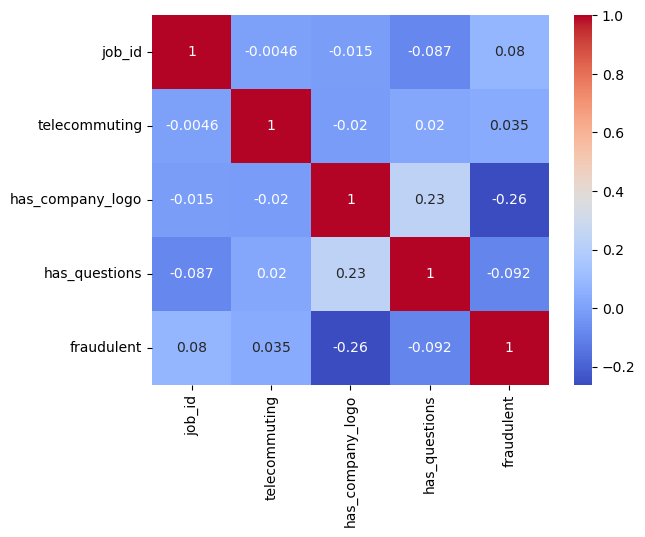

In [51]:
sns.heatmap(df[numerical].corr(), cmap = "coolwarm", annot= True )

cột `telecomuting` với cột `fraudulent` có độ tương đồng không cao có thế nói là không có  giúp ít gì trong việc dự đoán, tương tự với cột `has_questions` cũng vậy

In [52]:
numerical_has_drop = ["telecommuting","has_questions"]
df_drop_nu = df.drop(numerical_has_drop,axis=1)

<Axes: xlabel='has_company_logo', ylabel='count'>

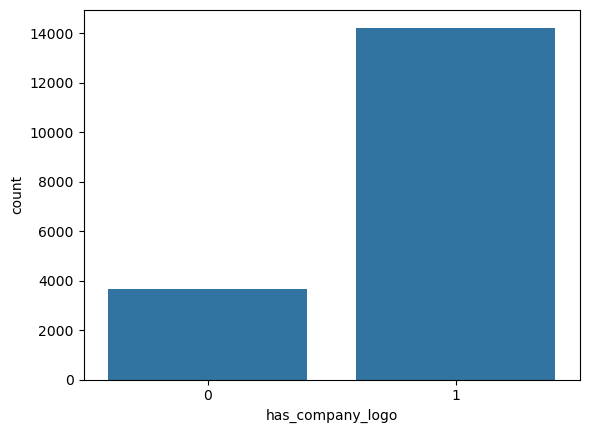

In [53]:
sns.countplot(x= 'has_company_logo',data = df)

In [54]:
df['location']

0            US, NY, New York
1              NZ, , Auckland
2               US, IA, Wever
3          US, DC, Washington
4          US, FL, Fort Worth
                 ...         
17875         CA, ON, Toronto
17876    US, PA, Philadelphia
17877         US, TX, Houston
17878           NG, LA, Lagos
17879       NZ, N, Wellington
Name: location, Length: 17880, dtype: object

mã quốc gia, mã bang/tỉnh,thành phố 

In [55]:
df['country'] = df['location'].str.split(",").str[0]
df['state'] = df['location'].str.split(',').str[1]
df['city'] = df['location'].str.split(',').str[2]

In [56]:
df['country'].unique()

array(['US', 'NZ', 'DE', 'GB', 'AU', 'SG', 'IL', 'AE', 'CA', 'IN', 'EG',
       'PL', 'GR', nan, 'PK', 'BE', 'BR', 'SA', 'DK', 'RU', 'ZA', 'CY',
       'HK', 'TR', 'IE', 'LT', 'JP', 'NL', 'AT', 'KR', 'FR', 'EE', 'TH',
       'PA', 'KE', 'MU', 'MX', 'RO', 'MY', 'FI', 'CN', 'ES', 'SE', 'CL',
       'UA', 'QA', 'IT', 'LV', 'IQ', 'BG', 'PH', 'CZ', 'VI', 'MT', 'HU',
       'BD', 'KW', 'LU', 'NG', 'RS', 'BY', 'VN', 'ID', 'ZM', 'NO', 'BH',
       'UG', 'CH', 'TT', 'SD', 'SK', 'AR', 'TW', 'PT', 'PE', 'CO', 'IS',
       'SI', 'MA', 'AM', 'TN', 'GH', 'AL', 'HR', 'CM', 'SV', 'NI', 'LK',
       'JM', 'KZ', 'KH'], dtype=object)

In [57]:
df['city'].unique()

array([' New York', ' Auckland', ' Wever', ..., ' Berkeley Heights',
       ' berlin', ' los Angeles'], dtype=object)

In [58]:
df['state'].unique()

array([' NY', ' ', ' IA', ' DC', ' FL', ' MD', ' BE', ' CA', ' AZ', ' NJ',
       ' LND', ' CT', ' NSW', ' 01', ' SOS', ' PA', ' TX', ' N', ' MO',
       ' ON', ' MA', ' KS', ' WA', ' AP', ' IL', nan, ' OK', ' NE', ' C',
       ' TN', ' OH', ' NH', ' NV', ' MN', ' I', ' DU', ' GA', ' KY',
       ' NC', ' SC', ' MB', ' WAR', ' IN', ' OR', ' WLV', ' BIR', ' BY',
       ' CO', ' MAN', ' TA', ' VA', ' AL', ' WI', ' MI', ' SD', ' CMD',
       ' QLD', ' UT', ' RDG', ' AR', ' E', ' MP', ' ME', ' RJ', ' AB',
       ' MT', ' DNC', ' LIN', ' LDS', ' MOW', ' SOM', ' EC', ' GBN',
       ' ESS', ' ENG', ' WSM', ' 34', ' BRU', ' NT', ' L', ' BC', ' VIC',
       ' QC', ' VL', ' 13', ' MH', ' UKM', ' 5', ' HCK', ' ISL', ' U',
       ' M', ' DE', ' SHF', ' 37', ' WKF', ' 10', ' NM', ' WV', ' 8',
       ' NL', ' 110', ' ABD', ' RI', ' SK', ' HAM', ' LA', ' QB', ' RIC',
       ' ANT', ' ND', ' J', ' NB', ' DIF', ' B', ' WY', ' HRY', ' WC',
       ' ID', ' 84', ' VOV', ' NW', ' CMA', ' IS', ' SWD', ' UP',

<Axes: xlabel='fraudulent', ylabel='count'>

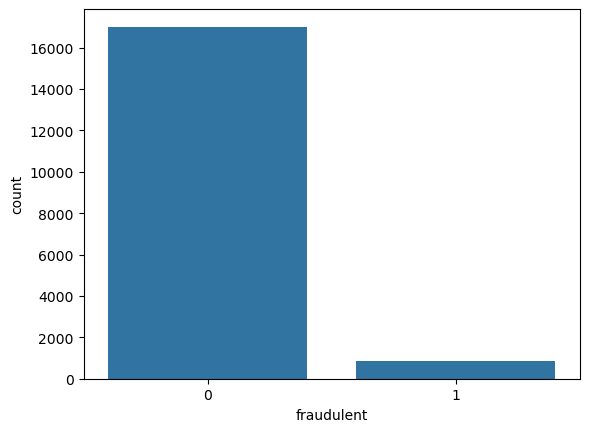

In [59]:
sns.countplot(data=df,x='fraudulent')

In [60]:
categorical.append(["country","state","city"])

In [61]:
# fill nan values by "unknow" and "missing"
text_features = ['company_profile','description','requirements','benefits']
for col in categorical:
    if col not in text_features:
        df[col]=df[col].fillna('unknow')
    else:
        df[col] = df[col].fillna("missng")

Text(0, 0.5, 'No. of Jobs')

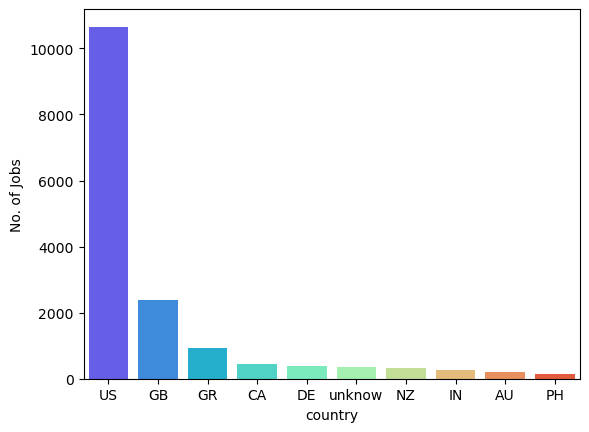

In [62]:
country = df['country'].value_counts().nlargest(10).index.tolist()
ax=sns.countplot(data=df, x='country', order=country, palette='rainbow')
ax.set_ylabel('No. of Jobs')

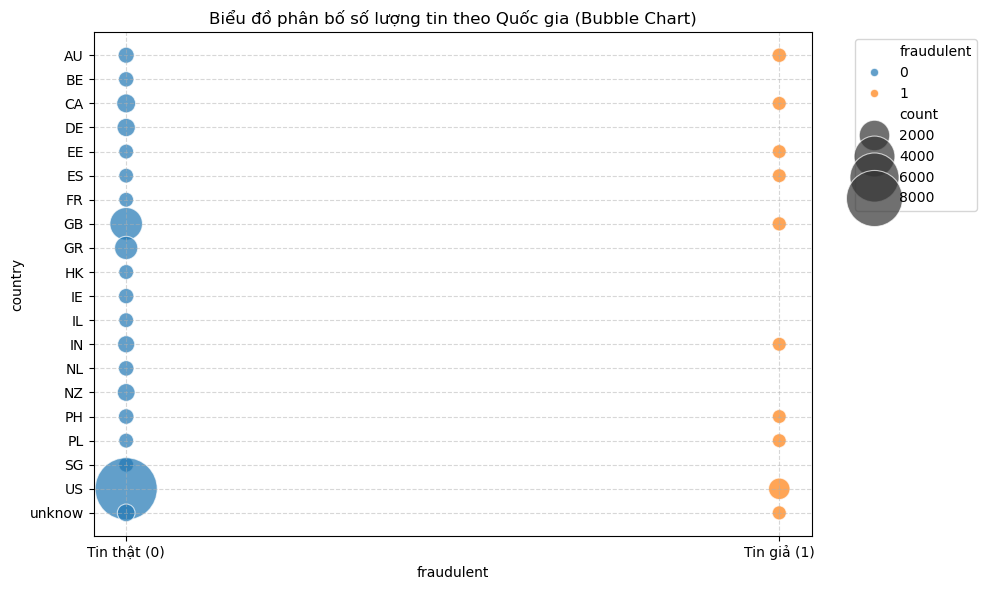

In [63]:

top_countries = df['country'].value_counts().head(20).index
df_filtered = df[df['country'].isin(top_countries)]
plot_data = df_filtered.groupby(['country', 'fraudulent']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=plot_data,
    x='fraudulent',      # Trục hoành: 0 và 1
    y='country',         # Trục tung: Tên các nước
    size='count',        # Kích thước điểm: Dựa vào cột số lượng
    hue='fraudulent',    # Màu sắc: Cũng dựa vào 0/1 cho dễ nhìn
    sizes=(100, 2000),   # Chỉnh độ to nhỏ của bong bóng (Min, Max)
    alpha=0.7            # Độ trong suốt (để các điểm đè lên nhau vẫn nhìn thấy)
)

plt.xticks([0, 1], ['Tin thật (0)', 'Tin giả (1)']) # Đổi nhãn trục X cho dễ hiểu
plt.grid(True, linestyle='--', alpha=0.5) # Thêm lưới mờ
plt.title('Biểu đồ phân bố số lượng tin theo Quốc gia (Bubble Chart)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Đưa chú thích ra ngoài

plt.tight_layout()
plt.show()

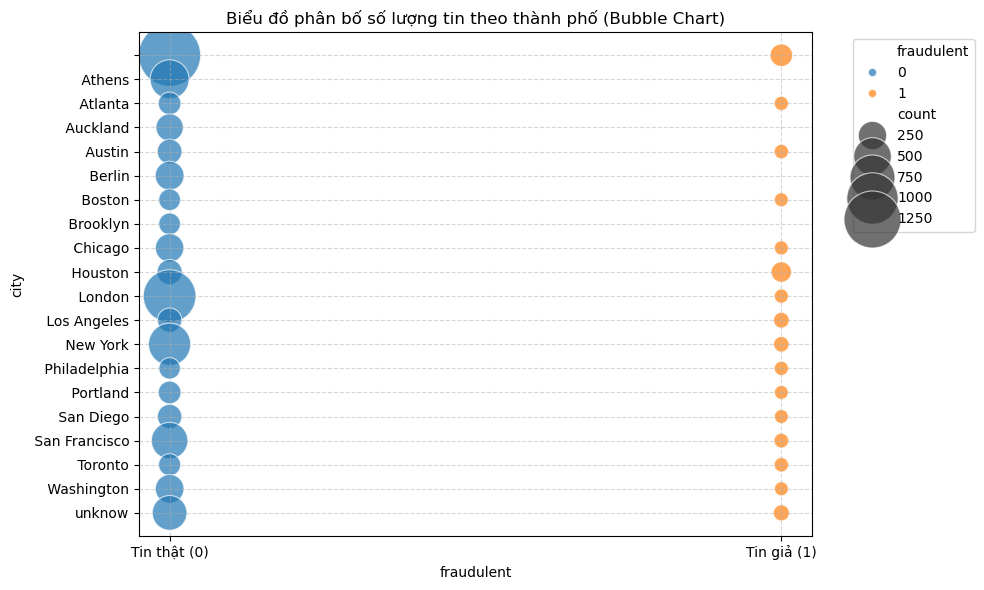

In [64]:
top_cities = df['city'].value_counts().head(20).index
df_filtered = df[df['city'].isin(top_cities)]
plot_data = df_filtered.groupby(['city', 'fraudulent']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=plot_data,
    x='fraudulent',      # Trục hoành: 0 và 1
    y='city',         # Trục tung: Tên các nước
    size='count',        # Kích thước điểm: Dựa vào cột số lượng
    hue='fraudulent',    # Màu sắc: Cũng dựa vào 0/1 cho dễ nhìn
    sizes=(100, 2000),   # Chỉnh độ to nhỏ của bong bóng (Min, Max)
    alpha=0.7            # Độ trong suốt (để các điểm đè lên nhau vẫn nhìn thấy)
)

plt.xticks([0, 1], ['Tin thật (0)', 'Tin giả (1)']) # Đổi nhãn trục X cho dễ hiểu
plt.grid(True, linestyle='--', alpha=0.5) # Thêm lưới mờ
plt.title('Biểu đồ phân bố số lượng tin theo thành phố (Bubble Chart)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Đưa chú thích ra ngoài

plt.tight_layout()
plt.show()

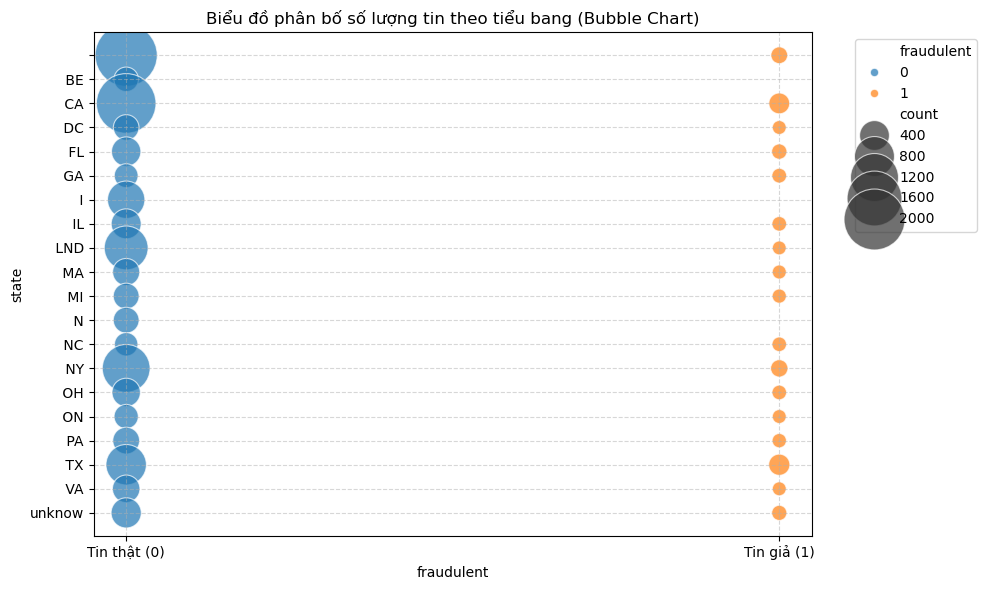

In [65]:
top_states = df['state'].value_counts().head(20).index
df_filtered = df[df['state'].isin(top_states)]
plot_data = df_filtered.groupby(['state', 'fraudulent']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=plot_data,
    x='fraudulent',      # Trục hoành: 0 và 1
    y='state',         # Trục tung: Tên các nước
    size='count',        # Kích thước điểm: Dựa vào cột số lượng
    hue='fraudulent',    # Màu sắc: Cũng dựa vào 0/1 cho dễ nhìn
    sizes=(100, 2000),   # Chỉnh độ to nhỏ của bong bóng (Min, Max)
    alpha=0.7            # Độ trong suốt (để các điểm đè lên nhau vẫn nhìn thấy)
)

plt.xticks([0, 1], ['Tin thật (0)', 'Tin giả (1)']) # Đổi nhãn trục X cho dễ hiểu
plt.grid(True, linestyle='--', alpha=0.5) # Thêm lưới mờ
plt.title('Biểu đồ phân bố số lượng tin theo tiểu bang (Bubble Chart)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Đưa chú thích ra ngoài

plt.tight_layout()
plt.show()

In [66]:
df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
country                0
state                  0
city                   0
dtype: int64

In [67]:
df['department'].value_counts()


department
unknow                                         11547
Sales                                            551
Engineering                                      487
Marketing                                        401
Operations                                       270
                                               ...  
Commercial Management / Contract Management        1
Exec                                               1
Marcomm                                            1
CRM                                                1
Hospitality                                        1
Name: count, Length: 1338, dtype: int64

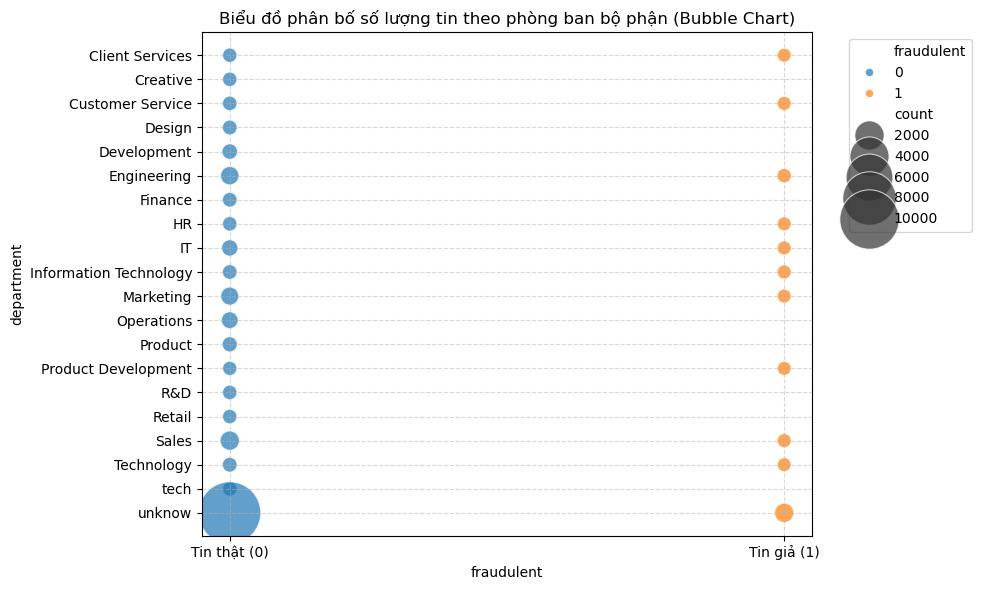

In [68]:
top_departments = df['department'].value_counts().head(20).index
df_filtered = df[df['department'].isin(top_departments)]
plot_data = df_filtered.groupby(['department', 'fraudulent']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=plot_data,
    x='fraudulent',      # Trục hoành: 0 và 1
    y='department',         # Trục tung: Tên các nước
    size='count',        # Kích thước điểm: Dựa vào cột số lượng
    hue='fraudulent',    # Màu sắc: Cũng dựa vào 0/1 cho dễ nhìn
    sizes=(100, 2000),   # Chỉnh độ to nhỏ của bong bóng (Min, Max)
    alpha=0.7            # Độ trong suốt (để các điểm đè lên nhau vẫn nhìn thấy)
)

plt.xticks([0, 1], ['Tin thật (0)', 'Tin giả (1)']) # Đổi nhãn trục X cho dễ hiểu
plt.grid(True, linestyle='--', alpha=0.5) # Thêm lưới mờ
plt.title('Biểu đồ phân bố số lượng tin theo phòng ban bộ phận (Bubble Chart)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Đưa chú thích ra ngoài

plt.tight_layout()
plt.show()

In [69]:
df['salary_range'].value_counts()

salary_range
unknow           15012
0-0                142
40000-50000         66
30000-40000         55
45000-67000         37
                 ...  
15-25                1
60-75                1
300000-325000        1
20-22                1
3700-3800            1
Name: count, Length: 875, dtype: int64

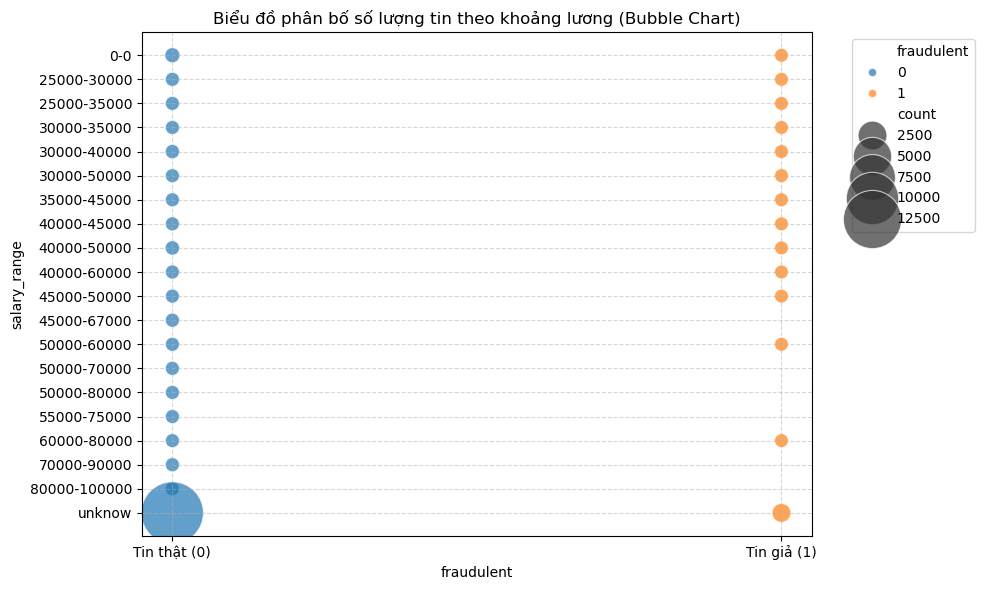

In [70]:
top_salary_range = df['salary_range'].value_counts().head(20).index
df_filtered = df[df['salary_range'].isin(top_salary_range)]
plot_data = df_filtered.groupby(['salary_range', 'fraudulent']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=plot_data,
    x='fraudulent',      # Trục hoành: 0 và 1
    y='salary_range',         # Trục tung: Tên các nước
    size='count',        # Kích thước điểm: Dựa vào cột số lượng
    hue='fraudulent',    # Màu sắc: Cũng dựa vào 0/1 cho dễ nhìn
    sizes=(100, 2000),   # Chỉnh độ to nhỏ của bong bóng (Min, Max)
    alpha=0.7            # Độ trong suốt (để các điểm đè lên nhau vẫn nhìn thấy)
)

plt.xticks([0, 1], ['Tin thật (0)', 'Tin giả (1)']) # Đổi nhãn trục X cho dễ hiểu
plt.grid(True, linestyle='--', alpha=0.5) # Thêm lưới mờ
plt.title('Biểu đồ phân bố số lượng tin theo khoảng lương (Bubble Chart)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Đưa chú thích ra ngoài

plt.tight_layout()
plt.show()

Text(0, 0.5, 'No. of Jobs')

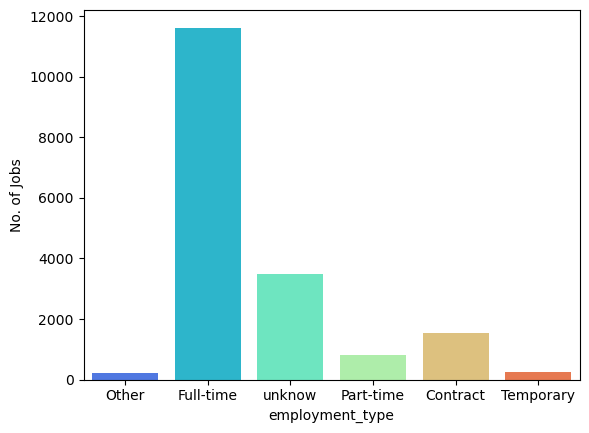

In [71]:
ax=sns.countplot(data=df, x='employment_type', palette='rainbow')
ax.set_ylabel('No. of Jobs')

Với những phân tích trên ta đã tìm ra thấy được độ quan trong của các cột dữ liệu 

Giời ta sẽ đi phân tích và xử lý các cột văn bản.

In [72]:
df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
country                0
state                  0
city                   0
dtype: int64

In [73]:
df['combined_text'] = df[['title', 'location', 'salary_range','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function','department']].apply(lambda x: ' '.join(x), axis=1)


df.drop(columns=['title',
                'location',
                'salary_range',
                'company_profile',
                'description',
                'requirements',
                'benefits',
                'employment_type',
                'required_experience',
                'required_education',
                'industry',
                'function',
                'department',
                'country',
                'state',
                'city'], inplace=True)

In [74]:
fake = df[df['fraudulent']==1]['combined_text']
real =  df[df['fraudulent']==0]['combined_text']

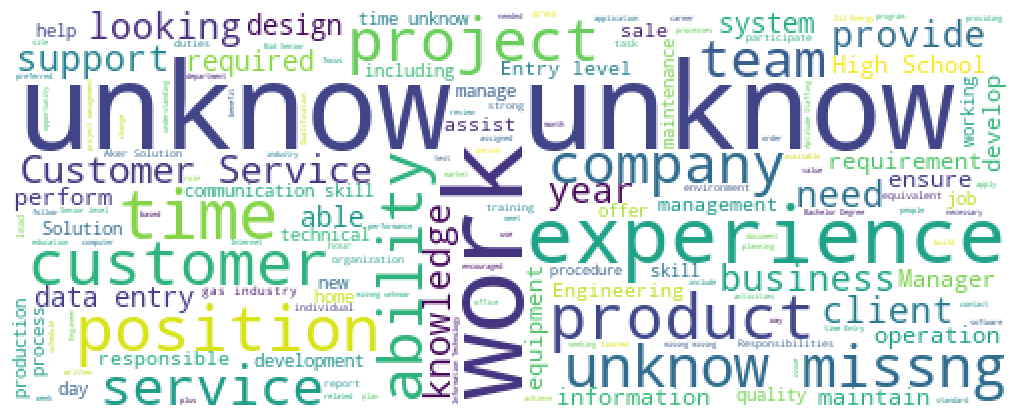

In [75]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

wordcloud = WordCloud(min_font_size=4,width=500, height=200, background_color='white',stopwords=STOPWORDS).generate(' '.join(fake))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

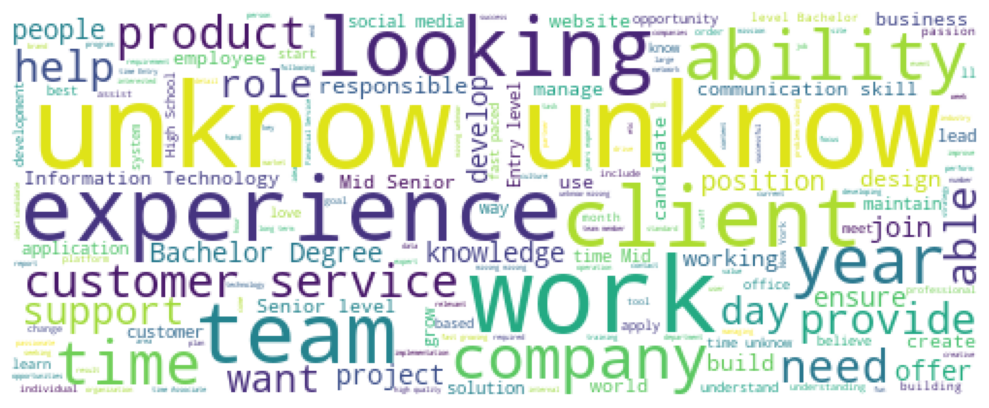

In [76]:
wordcloud = WordCloud(min_font_size=4,width=500, height=200, background_color='white',stopwords=STOPWORDS).generate(' '.join(real))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout()
plt.show()

In [77]:
fake_text = df[df['fraudulent'] == 1]['combined_text']
real_text = df[df['fraudulent'] == 0]['combined_text']

neg_words = ["no", "not", "never", "without", "none"]

for w in neg_words:
    fake_mean = fake_text.str.count(fr'\b{w}\b').mean()
    real_mean = real_text.str.count(fr'\b{w}\b').mean()
    print(w, fake_mean, real_mean)


no 0.1397228637413395 0.12742447396261902
not 0.3579676674364896 0.5872810626542847
never 0.009237875288683603 0.04002586105560127
without 0.04041570438799076 0.143646408839779
none 0.0011547344110854503 0.0044081344774891265


In [78]:
whilelist = []
for word in STOPWORDS:
    fake_mean = fake_text.str.count(fr'\b{re.escape(word)}\b').mean()
    real_mean = real_text.str.count(fr'\b{re.escape(word)}\b').mean()
    if fake_mean > real_mean:
        whilelist.append(word)
    else: continue


In [79]:
print(whilelist)

['much', 'say', 'my', 'any', 'own', 'serious', 'ours', 'within', 'others', 'six', 'whose', 'hence', 'eight', 'down', 'mostly', 'no', 'full', 'thereby', 'off', 'must', 'should', 'again', 'several', 'per', 'under', 'call', 'anywhere', 'toward', 'may', 'show', 'from', 'nothing', 'me', 'done', 'otherwise', 'hundred', 'above', 'third', 'your', 'below', 'he', 'ten', 'mine', 'amount', 'his', 'before', 'via', 'name', 'unless', 'amongst']


ở output trên ta tìm các được các từ dừng (stopword) ở phụ định như no có tác động đến việc phân loại dự đoán giả mạo.

In [80]:
chas =  df['combined_text'][1].lower()
print(chas)
keys = ['aker',"subsea",'action','novation']
count = 0 
for key in keys: 
    if key in chas:
        count +=1
    
print(count)


customer service - cloud video production nz, , auckland unknow 90 seconds, the worlds cloud video production service.90 seconds is the worlds cloud video production service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#url_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. with a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 seconds provides a 100% success guarantee.90 seconds has produced almost 4,000 videos in over 30 countries for over 500 global brands including some of the worlds largest incl

In [81]:
# --- 1. HÀM LÀM SẠCH (QUAN TRỌNG NHẤT) ---
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # 1. Chuyển thành chữ thường
    text = text.lower()
    
    # 2. Loại bỏ thẻ HTML (ví dụ: <br>, <div>, <li>)
    text = re.sub(r'<.*?>', ' ', text)
    
    # 3. Loại bỏ ký tự đặc biệt và số (chỉ giữ lại chữ cái)
    # Nếu muốn giữ số lương thì sửa thành [^a-z0-9\s]
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 4. Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# --- 2. CHUẨN BỊ DỮ LIỆU ---
# Đảm bảo index chuẩn
df = df.reset_index(drop=True)
df['fraudulent'] = pd.to_numeric(df['fraudulent'], errors='coerce').fillna(0).astype(int)

# Gộp cột (Nếu chưa gộp)
# df['combined_text'] = df['title'] + ' ' + df['description'] + ' ' + df['requirements']

# Xử lý thiếu
df['combined_text'] = df['combined_text'].fillna("").astype(str)

# ÁP DỤNG HÀM LÀM SẠCH (Đây là bước bạn bị thiếu)
print("Đang làm sạch dữ liệu... (Vui lòng đợi)")
df['combined_text'] = df['combined_text'].apply(clean_text)

# --- 3. TRÍCH XUẤT TỪ KHÓA ---
if sum(df['fraudulent'] == 1) == 0:
    print("❌ LỖI: Không có tin giả nào trong dữ liệu!")
else:
    # Cấu hình Vectorizer
    # - ngram_range=(1, 2): Lấy cả cụm 2 từ (ví dụ: "data entry" sẽ có nghĩa hơn là "data" đứng một mình)
    # - min_df=5: Bỏ qua các từ xuất hiện quá ít (dưới 5 lần) -> Giảm rác
    vec = CountVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2), min_df=5)
    
    X = vec.fit_transform(df['combined_text'])
    feature_names = vec.get_feature_names_out()

    # Tách nhóm
    mask_fake = (df['fraudulent'] == 1).values
    mask_real = (df['fraudulent'] == 0).values
    
    fraud_counts = np.array(X[mask_fake].sum(axis=0)).flatten()
    real_counts = np.array(X[mask_real].sum(axis=0)).flatten()

    # Tính toán
    total_fraud = fraud_counts.sum()
    total_real = real_counts.sum()
    
    df_freq = pd.DataFrame({
        'word': feature_names,
        'fraud_count': fraud_counts,
        'real_count': real_counts
    })
    
    # Chuẩn hóa tần suất (để so sánh công bằng)
    df_freq['fraud_rate'] = (df_freq['fraud_count'] + 1) / (total_fraud + 1)
    df_freq['real_rate'] = (df_freq['real_count'] + 1) / (total_real + 1)
    
    # Tính điểm số khác biệt (Difference Score)
    # Điểm càng cao -> Càng đặc trưng cho Tin Giả
    df_freq['score'] = df_freq['fraud_rate'] / df_freq['real_rate']
    
    # Lọc bỏ từ rác (những từ chỉ xuất hiện vài lần ở tin giả)
    df_freq = df_freq[df_freq['fraud_count'] > 10] 

    print("\n=== TOP 20 TỪ KHÓA/CỤM TỪ ĐẶC TRƯNG CỦA TIN GIẢ ===")
    print(df_freq.sort_values(by='score', ascending=False)[['word', 'fraud_count', 'real_count', 'score']].head(20))

Đang làm sạch dữ liệu... (Vui lòng đợi)

=== TOP 20 TỪ KHÓA/CỤM TỪ ĐẶC TRƯNG CỦA TIN GIẢ ===
                          word  fraud_count  real_count      score
3187                 petroleum          101          76  35.549309
2964                   oil gas          197         162  32.598627
1438        engineering design           88          74  31.845675
1048                data entry          281         301  25.059008
1420                encouraged          143         182  21.117044
4603                    typing          129         167  20.766140
2963                oil energy          137         179  20.574453
658                   clerical           81         109  20.005199
4130          solutions global           85         117  19.558618
4545         training provided           77         110  18.857901
4901                 work home          140         204  18.458099
659                      clerk           97         143  18.263554
89    administrative assistant      

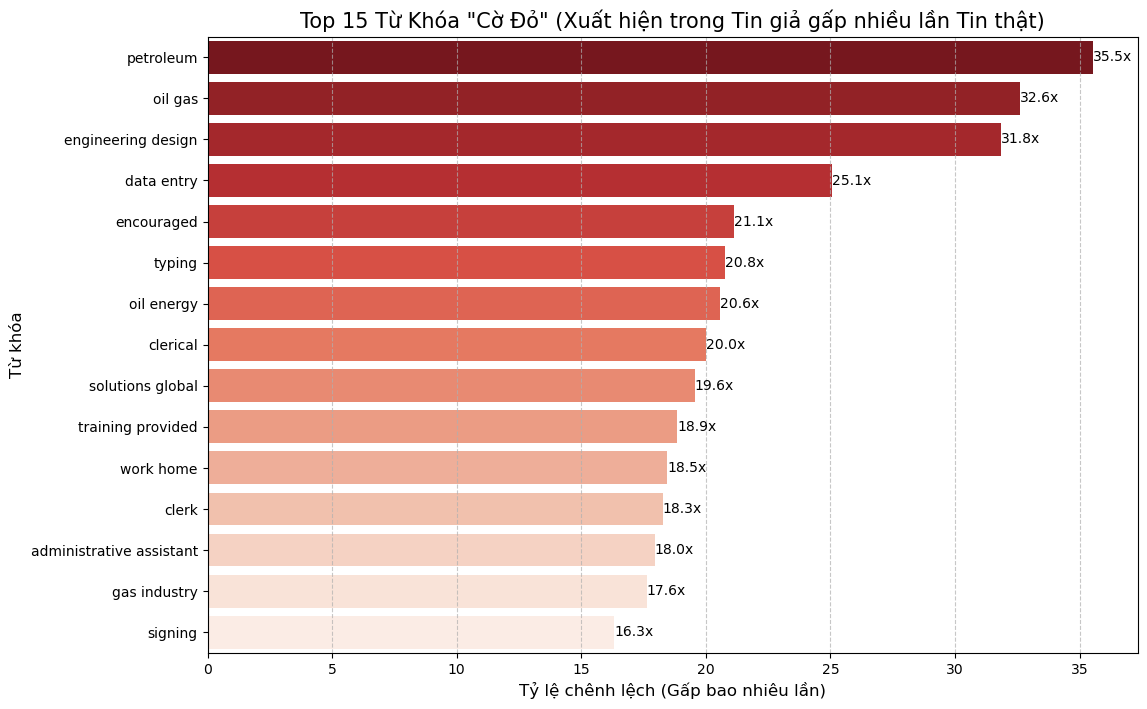

In [82]:
# Lấy Top 15 từ khóa lừa đảo
top_fraud_words = df_freq.sort_values(by='score', ascending=False).head(15)

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(data=top_fraud_words, x='score', y='word', palette='Reds_r')

plt.title('Top 15 Từ Khóa "Cờ Đỏ" (Xuất hiện trong Tin giả gấp nhiều lần Tin thật)', fontsize=15)
plt.xlabel('Tỷ lệ chênh lệch (Gấp bao nhiêu lần)', fontsize=12)
plt.ylabel('Từ khóa', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Thêm chú thích giá trị lên đầu cột
for index, value in enumerate(top_fraud_words['score']):
    plt.text(value, index, f'{value:.1f}x', va='center')

plt.show()

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy Top 15 từ khóa lừa đảo
top_fraud_words = df_freq.sort_values(by='fraud_ratio', ascending=False).head(15)

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(data=top_fraud_words, x='fraud_ratio', y='word', palette='Reds_r')

plt.title('Top 15 Từ Khóa "Cờ Đỏ" (Xuất hiện trong Tin giả gấp nhiều lần Tin thật)', fontsize=15)
plt.xlabel('Tỷ lệ chênh lệch (Gấp bao nhiêu lần)', fontsize=12)
plt.ylabel('Từ khóa', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Thêm chú thích giá trị lên đầu cột
for index, value in enumerate(top_fraud_words['fraud_ratio']):
    plt.text(value, index, f'{value:.1f}x', va='center')

plt.show()

KeyError: 'fraud_ratio'

Từ những kết quả trên ta đã có thể trả lời được câu hỏi nghiên cứu là Các cột và keyword nào ảnh hưởng mạnh đến khả năng dự đoán của mô hình 
+ với các cột dạng số thì ta thấy được `has_company` có điểm tương đồng thuận khá cao với `fraudulent` các cột khác cũng có sự ảnh hưởng tương đố cho dự đoán chỉ có cột job_id là không có giúp dự đoán chính xác hơn mà ngược lại nó có thế ảnh hưởng cản trở đến việc dự đoán. 
+ với cột dạng categorical thì đều giúp cho mô hình dự đoán phân loại.
+ ở Cột dạng Text thì ta cần tìm các từ stopWords có ảnh hưởng đến việc phân loại nên ta cần xác định chúng giữ chúng lại để ko bị loại bỏ -> từ bộ dữ liệu ta xác định được 50 từ stopwords có ảnh hưởng đến mô hình. 
+ Thêm vào đó ta cũng đã xác định được các từ khóa (keynote) ảnh hưởng nhiều nhất đến mô hình là `petroleum, oil gas,oil energy,data entry,typing,clerical,work home,training provided, encouraged, administrative assitantm clerk` 
    + Xác định keynote xong thì làm sao để nhưng từ khóa đó giúp mô hình tăng mạnh khả năng dự đoán: tạo 1 cột nếu có chứa các keynote thì sẽ là 1


In [ ]:
key = ['aker',"subsea",'action','novation']
char = '0fa3f7c5e23a16de16a841e368006cae916884407d90b154dfef3976483a71ae'
pattern = "|".join(key)

df['key_note'] = df['combined_text'].str.contains(pattern, case=False, na=False).astype(int)
print(df['key_note'].value_counts())
print(df[df['key_note'] == 1][['combined_text', 'fraudulent', 'key_note']].head())

key_note
0    11758
1     6122
Name: count, dtype: int64
                                       combined_text  fraudulent  key_note
1  customer service cloud video production nz auc...           0         1
3  account executive washington dc dc washington ...           0         1
4  bill review manager fl fort worth unknow spots...           0         1
5  accounting clerk md unknow missng job overview...           0         1
6  head content m f de berlin 20000 28000 found 2...           0         1


In [ ]:
df[df['key_note'] == 1][['combined_text','job_id']].head(1)

,combined_text,job_id
1,customer service cloud video production nz auc...,2


In [ ]:
df['chain'] = df['combined_text'].str.contains(char,case=False,na=False).astype(int)

# Hoàn thành

In [84]:
path_save = os.path.join(project_root,"reports")
print(path_save)

d:\PYTHON\data_mining\fraud-detection-post\reports


In [85]:
!jupyter nbconvert --to html "analysis.ipynb" --output-dir "$path_save"

[NbConvertApp] Converting notebook analysis.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 13 image(s).
[NbConvertApp] Writing 1392916 bytes to d:\PYTHON\data_mining\fraud-detection-post\reports\analysis.html
